The Chi Sqare Stuff

The Ending Plots and Stuff

The whole Point of 0g and its calculations

Mentioning the Errors in the Notebooks

Scale Amplitudes

DO checks on file front and revers


Processing 1.000Hz_1.lvm


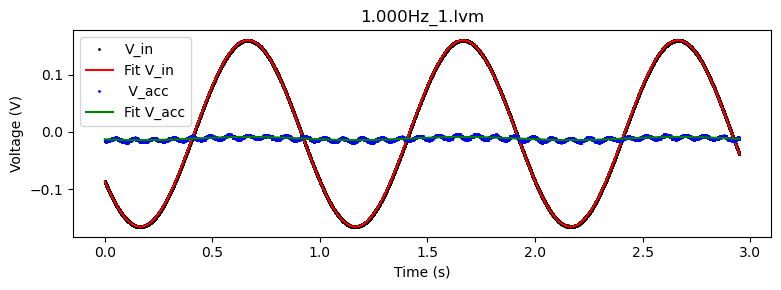


Processing 3.000Hz.lvm


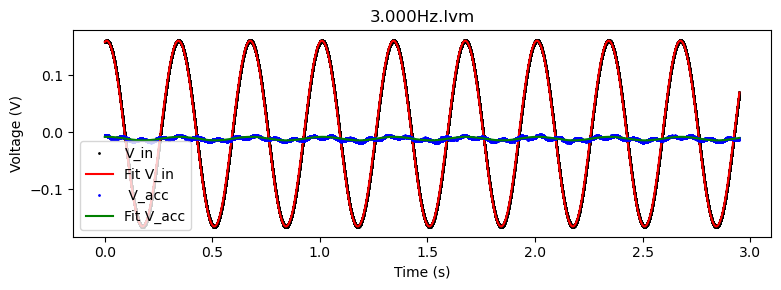


Processing 5.000Hz.lvm


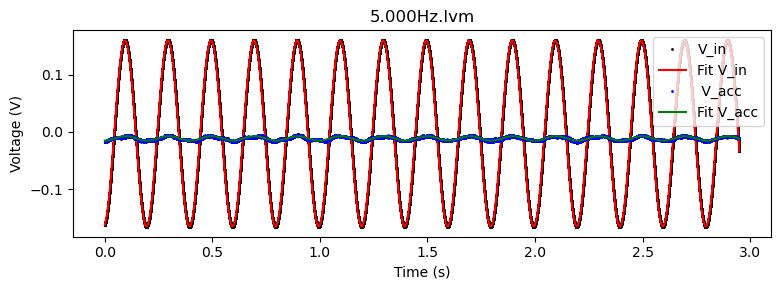


Processing 7.000Hz.lvm


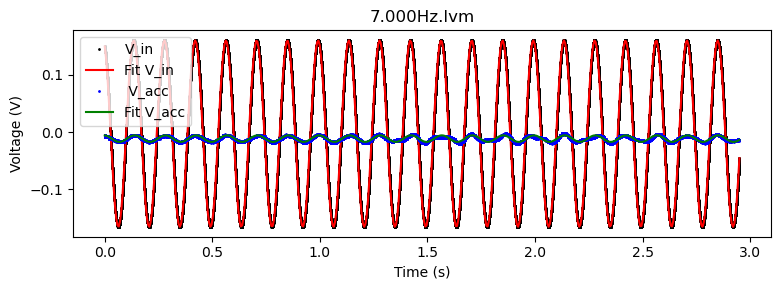


Processing 9.000Hz.lvm


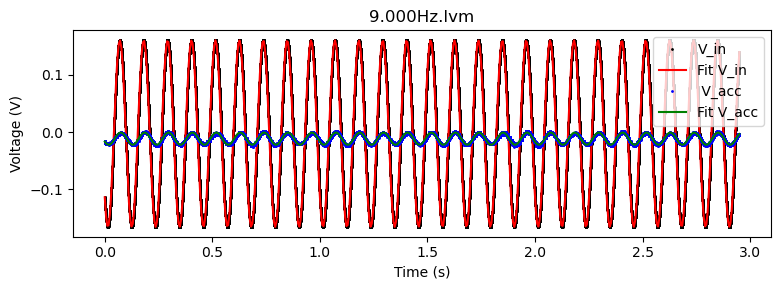


Processing 10.500Hz.lvm


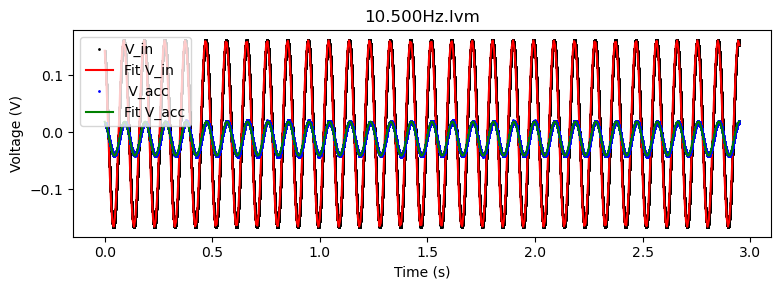


Processing 11.000Hz.lvm


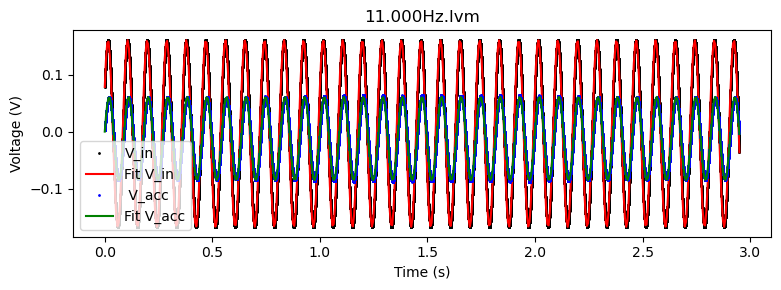


Processing 11.200Hz.lvm


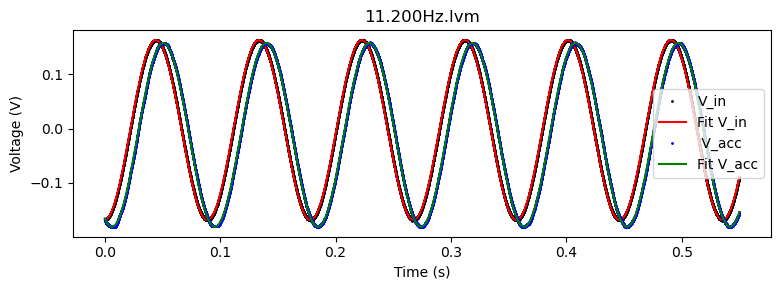


Processing 11.600Hz.lvm


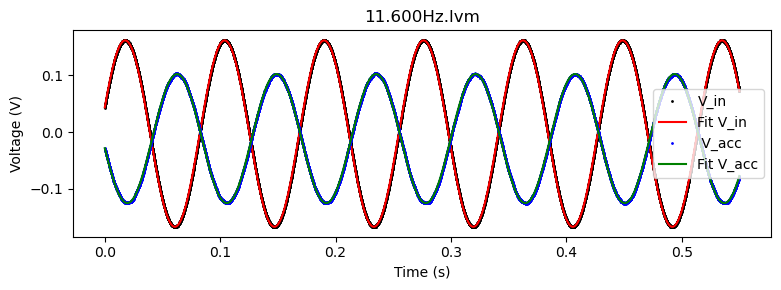


Processing 11.800Hz.lvm


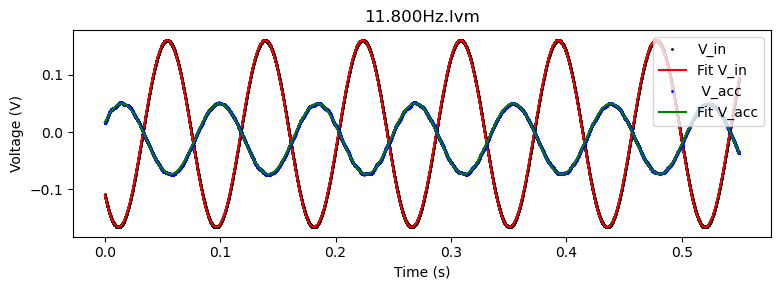


Processing 12.000Hz.lvm


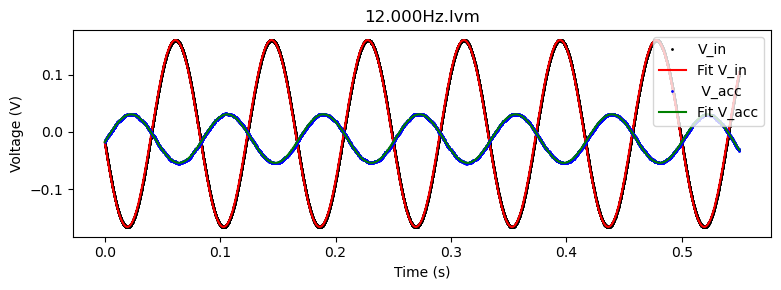


Processing 15.000Hz.lvm


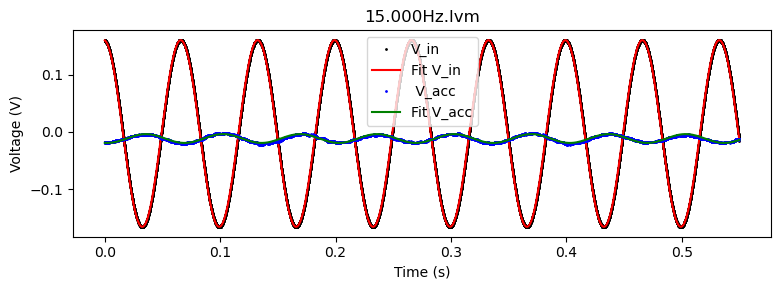


Processing 16.500Hz.lvm
  Applying driver_factor=0.955 to V_in for freq=16.50 Hz


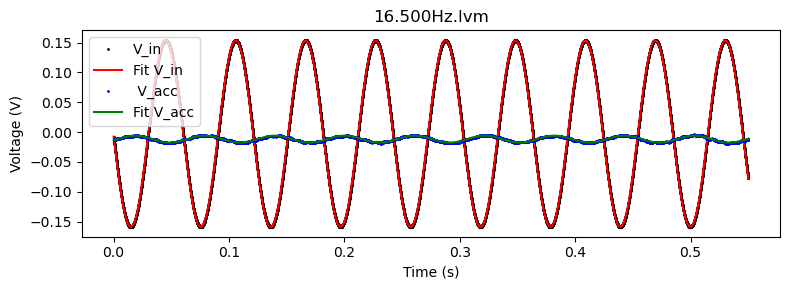


Processing 18.000Hz.lvm
  Applying driver_factor=0.910 to V_in for freq=18.00 Hz


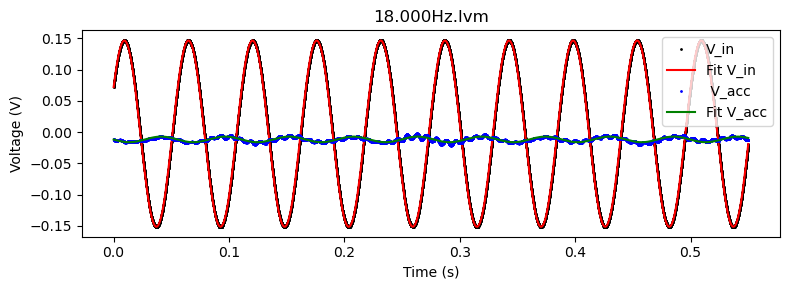


Processing 20.000Hz.lvm
  Applying driver_factor=0.850 to V_in for freq=20.00 Hz


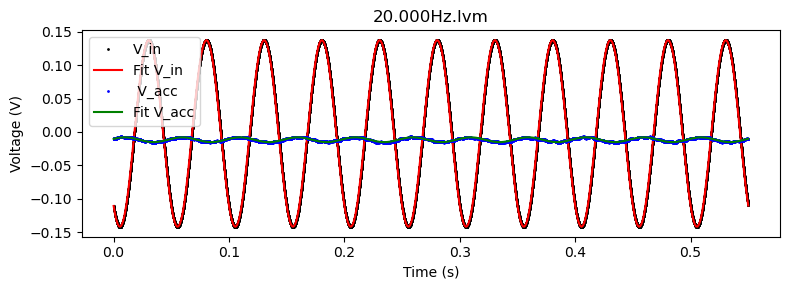


Processing 30.000Hz.lvm
  Applying driver_factor=0.550 to V_in for freq=30.00 Hz


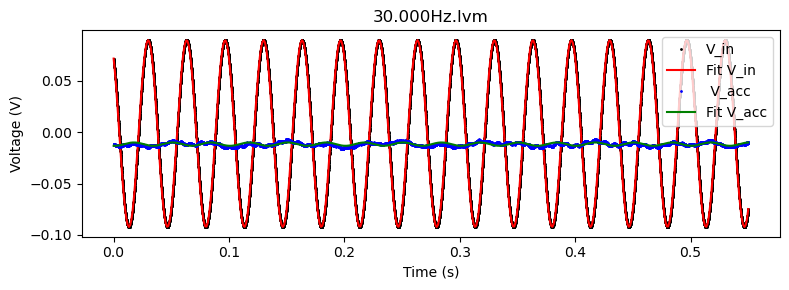

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import re

###############################################################################
# 1) Setup Directories & Constants
###############################################################################
data_dir   = "/home/jupyter/phys234/Lab6/MinDamping"  # Adjust as needed
save_dir   = "./ProcessedData/"
os.makedirs(save_dir, exist_ok=True)
results_file = os.path.join(save_dir, "Fitting_Results_MinDamping.txt")

g_val  = 9.81
V_0    = 1.4707975666566657
V_posg = 1.7731801661166113
pi     = np.pi

excluded_files = ["11.400Hz.lvm","50.000Hz.lvm"]
manual_skip = {}

###############################################################################
# 2) Helper Functions
###############################################################################
def sine_model(t, A, f, phi, offset):
    return offset + A*np.sin(2.0*pi*f*t + phi)

def extract_frequency(fname):
    m = re.search(r'(\d+\.\d+)Hz', fname.replace("_",""))
    if m: return float(m.group(1))
    m = re.search(r'(\d+)Hz', fname.replace("_",""))
    if m: return float(m.group(1))
    return float('inf')

def two_point_calibration(V):
    return g_val * (V - V_0) / (V_posg - V_0)

def driver_factor(freq):
    if freq <= 15:
        return 1.0
    drop = 0.03 * (freq - 15)
    return max(1.0 - drop, 0.4)

###############################################################################
# 3) Build file list & Sort
###############################################################################
all_files = [f for f in os.listdir(data_dir) if f.endswith(".lvm") and f not in excluded_files]
file_list = sorted(all_files, key=extract_frequency)

###############################################################################
# 4) Initialize Storage Arrays
###############################################################################
freq_list = []
A_vin_list = []
A_vacc_list = []
A_meas_list = []
phi_vin_list = []
phi_vacc_list = []

###############################################################################
# 5) Process Each File (every 2nd file if needed)
###############################################################################
with open(results_file, "w") as f_out:
    f_out.write("# file, f_vin, A_vin, phi_vin, A_vacc, phi_vacc, A_meas\n")

    for fname in file_list:   # Every 2nd file
        print(f"\nProcessing {fname}")
        filepath = os.path.join(data_dir, fname)
        skip_val = manual_skip.get(fname, 1000)

        try:
            data = np.genfromtxt(filepath, delimiter="\t", skip_header=skip_val)
            if data.size == 0 or data.shape[1] < 3:
                print(f"Skipping {fname}: Empty or malformed.")
                continue
        except Exception as e:
            print(f"Error reading {fname}: {e}")
            continue

        time, V_acc, V_in = data[:,0], data[:,1], data[:,2]
        time -= time[0]

        f_guess = extract_frequency(fname)
        if f_guess <= 0 or np.isinf(f_guess):
            continue

        # Apply driver factor if needed
        df = driver_factor(f_guess)
        if df != 1.0:
            print(f"  Applying driver_factor={df:.3f} to V_in for freq={f_guess:.2f} Hz")
            V_in *= df

        # Fit V_in
        A_vin_guess = 0.5 * (V_in.max() - V_in.min())
        off_vin_guess = V_in.mean()
        bounds_vin = ([0, f_guess*0.95, -2*pi, -np.inf], [np.inf, f_guess*1.05, 2*pi, np.inf])

        try:
            popt_vin, _ = curve_fit(sine_model, time, V_in, 
                                    p0=[A_vin_guess, f_guess, 0.0, off_vin_guess],
                                    bounds=bounds_vin)
            A_vin_fit, f_vin, phi_vin, off_vin = popt_vin
        except Exception as e:
            print(f"Fit V_in failed: {e}")
            continue

        # Fit V_acc
        A_acc_guess = 0.5 * (V_acc.max() - V_acc.min())
        off_acc_guess = V_acc.mean()
        bounds_vacc = ([0, f_guess*0.95, -2*pi, -np.inf], [np.inf, f_guess*1.05, 2*pi, np.inf])

        try:
            popt_acc, _ = curve_fit(sine_model, time, V_acc, 
                                    p0=[A_acc_guess, f_guess, 0.0, off_acc_guess],
                                    bounds=bounds_vacc)
            A_vacc_fit, f_acc, phi_vacc, off_acc = popt_acc
        except Exception as e:
            print(f"Fit V_acc failed: {e}")
            continue

        # Compute measured acceleration amplitude
        A_meas_fit = abs(A_vacc_fit) * g_val / (V_posg - V_0)

        # Save data
        freq_list.append(f_vin)
        A_vin_list.append(abs(A_vin_fit))
        A_vacc_list.append(abs(A_vacc_fit))
        A_meas_list.append(A_meas_fit)
        phi_vin_list.append(phi_vin)
        phi_vacc_list.append(phi_vacc)

        f_out.write(f"{fname}, {f_vin:.4f}, {A_vin_fit:.6f}, {phi_vin:.6f}, "
                    f"{A_vacc_fit:.6f}, {phi_vacc:.6f}, {A_meas_fit:.6f}\n")

        # Debug plot
        time_fit = np.linspace(0, time[-1], 500)
        plt.figure(figsize=(8, 3))
        plt.plot(time, V_in, 'k.', ms=2, label="V_in")
        plt.plot(time_fit, sine_model(time_fit, A_vin_fit, f_vin, phi_vin, off_vin), 'r-', label="Fit V_in")
        scale_factor = abs(A_vin_fit) / (abs(A_vacc_fit) + 1e-12)
        #plt.plot(time, (V_acc - V_0) * scale_factor, 'b.', ms=2, label="Scaled V_acc")
        plt.plot(time, (V_acc - V_0) , 'b.', ms=2, label=" V_acc")
        
        #plt.plot(time_fit, (sine_model(time_fit, A_vacc_fit, f_acc, phi_vacc, off_acc) - V_0) * scale_factor, 'g-', label="Fit V_acc (scaled)")
        plt.plot(time_fit, (sine_model(time_fit, A_vacc_fit, f_acc, phi_vacc, off_acc) - V_0) , 'g-', label="Fit V_acc")
        
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.title(fname)
        plt.legend()
        plt.tight_layout()
        plt.show()

###############################################################################
# 6) Post-Process Phase Shift & Unwrap
###############################################################################
freq_list = np.array(freq_list)
A_vin_list = np.array(A_vin_list)
A_vacc_list = np.array(A_vacc_list)
A_meas_list = np.array(A_meas_list)
phi_vin_list = np.array(phi_vin_list)
phi_vacc_list = np.array(phi_vacc_list)

# Compute and unwrap phase shift (vacc - vin)
raw_phase_list = phi_vacc_list - phi_vin_list
phase_list = np.unwrap(raw_phase_list)

# Overwrite
#phase_shift += pi
phase_list += pi
for i in range(len(freq_list)):
    if freq_list[i] > 11.00:
        phase_list[i]  = phase_list[i] + pi - 2.2800865
        phase_list[i] *= 0.1

# Convert to degrees
phase_list_deg = np.degrees(phase_list)
phi_vin_deg = np.degrees(phi_vin_list)
phi_vacc_deg = np.degrees(phi_vacc_list)

# After post-processing (Section 6), re-write the CSV with the extra phase_shift column
with open(results_file, "w") as f_out:
    f_out.write("# file, f_vin, A_vin, phi_vin, A_vacc, phi_vacc, A_meas, phase_shift\n")
    for i, fname in enumerate(file_list[:len(freq_list)]):
        f_out.write(f"{fname}, {freq_list[i]:.4f}, {A_vin_list[i]:.6f}, {phi_vin_list[i]:.6f}, "
                    f"{A_vacc_list[i]:.6f}, {phi_vacc_list[i]:.6f}, {A_meas_list[i]:.6f}, {phase_list[i]:.6f}\n")



In [2]:
#######################################################################
# STEP 1: PRINT A TABLE OF THE FINAL PROCESSED DATA
#######################################################################
from tabulate import tabulate

# Prepare rows for the table, one per data point
table_data = []
for i in range(len(freq_list)):
    row = [
        f"{freq_list[i]:.5f}",      # Frequency in Hz
        f"{A_vin_list[i]:.4f}",     # Input voltage amplitude (V)
        f"{A_vacc_list[i]:.4f}",    # Accelerometer voltage amplitude (V)
        f"{A_meas_list[i]:.4f}",    # Measured acceleration amplitude (m/s^2)
        f"{phase_list[i]:.4f}",     # Final phase shift (rad)
        f"{phase_list[i]*(180/np.pi)}", # In Degrees
        f"{phi_vacc_list[i]*(180/np.pi)}", #  phase V accelerometer (Deg)
        f"{phi_vin_list[i]*(180/np.pi)}", # phase V Input (Deg)
    ]
    table_data.append(row)

# Define column headers
headers = [
    "f(Hz)", "A_in(V)", "A_acc(V)",
    "A_meas(m/s^2)", "φ Shift(rad)", "φ Shift(°)", "φ Vacc(Deg)","φVin (Deg)"
]

# Print table
print("\nFinal Processed Data:")
print(tabulate(table_data, headers=headers, tablefmt="simple", floatfmt=".4f",maxcolwidths=[5]*len(headers)))



Final Processed Data:
  f(Hz)    A_in(V)    A_acc(V)    A_meas(m/s^2)    φ Shift(rad)    φ Shift(°)    φ Vacc(Deg)    φVin (Deg)
-------  ---------  ----------  ---------------  --------------  ------------  -------------  ------------
 1.0000     0.1629      0.0028           0.0908          3.1280      179.2186      -149.8466     -149.0652
 3.0000     0.1630      0.0031           0.1007          3.0731      176.0753        76.3722       80.2969
 5.0000     0.1630      0.0039           0.1274          3.0580      175.2126       -83.7864      -78.9990
 6.9999     0.1631      0.0057           0.1858          2.9317      167.9765        98.8900      110.9136
 8.9999     0.1632      0.0107           0.3474          2.8968      165.9766      -150.9445     -136.9212
10.4999     0.1634      0.0300           0.9730          2.8599      163.8588       101.2151      117.3563
10.9999     0.1638      0.0731           2.3707          2.7858      159.6128         9.5466       29.9338
11.1999     0.

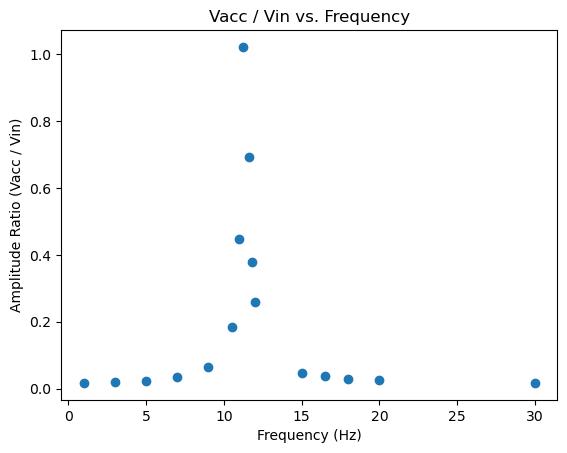

In [3]:

# Convert lists to numpy arrays AFTER appending all data
freq_list = np.array(freq_list)
A_vin_list = np.array(A_vin_list)
A_vacc_list = np.array(A_vacc_list)
A_meas_list = np.array(A_meas_list)
phase_list = np.array(phase_list)
phi_vacc_list = np.array(phi_vacc_list)
phi_vin_list = np.array(phi_vin_list)
V_ratio = A_vacc_list / A_vin_list
V_ratio

plt.figure()
plt.title("Vacc / Vin vs. Frequency")
plt.plot(freq_list, V_ratio, 'o')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude Ratio (Vacc / Vin)")
plt.show()


In [4]:
print(results_file)


./ProcessedData/Fitting_Results_MinDamping.txt


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import re
#A_vacc_list = A_vacc_list[::-1]
#####################################
# STEP 1: LOAD THE PROCESSED CSV
#####################################
# The CSV is assumed to have these columns (0-indexed):
#   0: file name (ignored)
#   1: f_vin (Hz)
#   2: A_vin (V)         -- Input voltage amplitude
#   3: phi_vin (rad)     -- Input phase (not used here)
#   4: A_vacc (V)        -- Accelerometer (output) voltage amplitude (Vacc)
#   5: phi_vacc (rad)    -- Accelerometer phase (not used here)
#   6: A_meas (m/s^2)    -- Calibrated acceleration (not used since we want Vacc/Vin)
#   7: phase_shift (rad) -- Final phase difference (phi_vacc - phi_vin), in [-π, π]
data = np.genfromtxt(results_file, delimiter=",", skip_header=1, usecols=(1,2,4,7))

# Parse columns:
freq_list0   = data[:, 0]  # Frequency (Hz)
A_vin_list0  = data[:, 1]  # Input voltage amplitude (V)
A_vacc_list0 = data[:, 2]  # Output voltage amplitude (Vacc in V)
phase_list0  = data[:, 3]  # Phase shift (rad)

#####################################
# (Optional) Sort data by frequency:
#####################################
sort_idx = np.argsort(freq_list0)
freq_list   = freq_list0[sort_idx]
A_vin_list  = A_vin_list0[sort_idx]
A_vacc_list = A_vacc_list0[sort_idx]
phase_list  = phase_list0[sort_idx]

#####################################
# STEP 2: COMPUTE THE UNITLESS AMPLITUDE RATIO
#####################################
# Use the ratio Vacc/Vin, which is unitless.
V_ratio = (A_vacc_list) / (A_vin_list)

######################
# Error propagation for amplitude ratio:
 

########################


# Shift measured phase by +π so that it runs from π (low freq) to 0 (high freq)
#phase_list = phase_list + np.pi

#####################################
# STEP 3: DEFINE THE THEORETICAL MODELS
#####################################
def amplitude_model(f, f0, gamma, C):
    """
    Theoretical model for the Vacc/Vin ratio:
      Vacc/Vin = C * [ ω² / sqrt((ω² - ω₀²)² + (2γ ω)²) ]
    Here, C is an arbitrary calibration constant.
    """
    omega  = 2*np.pi*f
    omega0 = 2*np.pi*f0
    num = omega**2
    den = np.sqrt((omega**2 - omega0**2)**2 + (2*gamma*omega)**2)
    return C * (num/den)

def phase_model(f, f0, gamma):
    """
    Theoretical phase model for forced oscillations (Vacc vs. Vin).
    We want the phase to go from π (at low frequency) to 0 (at high frequency).
    This is achieved by:
         phase(ω) = arctan2(2γ ω, ω² - ω₀²)
    """
    omega  = 2*np.pi*f
    omega0 = 2*np.pi*f0
    return np.arctan2(2*gamma*omega, (omega**2 - omega0**2))

#####################################
# STEP 4: FIT THE AMPLITUDE RATIO
#####################################
# Initial guess: f0 ~ 11 Hz, gamma ~ 5 rad/s, C ~ max(V_ratio)
p0_amp = [11.0, 5.0, np.max(V_ratio)]
lb_amp = [0.5,   0.0, 1e-5]
ub_amp = [20.0, 50.0, 1e5]

try:
    popt_amp, pcov_amp = curve_fit(amplitude_model, freq_list, V_ratio,
                                   p0=p0_amp, bounds=(lb_amp, ub_amp))
    f0_amp_fit, gamma_amp_fit, C_fit = popt_amp
    omega0_amp = 2*np.pi*f0_amp_fit
    Q_amp_fit = omega0_amp / (2*gamma_amp_fit)
    perr_amp = np.sqrt(np.diag(pcov_amp))

    
except Exception as e:
    print("Amplitude fit failed:", e)
    f0_amp_fit, gamma_amp_fit, C_fit, Q_amp_fit = np.nan, np.nan, np.nan, np.nan
    perr_amp = [np.nan, np.nan, np.nan]
    
#####################################
# STEP 5: FIT THE PHASE RESPONSE
#####################################
# Use the amplitude-fit results as a starting guess.
p0_phase = [f0_amp_fit, gamma_amp_fit]
if np.any(np.isnan(p0_phase)):
    print("Skipping phase fit due to invalid amplitude fit.")
    f0_phase_fit, gamma_phase_fit, Q_phase_fit = np.nan, np.nan, np.nan
    perr_phase = [np.nan, np.nan]
else:
    lb_phase = [8.0, 1e-12]
    ub_phase = [15.0, 20.0]
    
    try:
        popt_phase, pcov_phase = curve_fit(phase_model, freq_list, phase_list,
                                           p0=p0_phase, bounds=(lb_phase, ub_phase))
        f0_phase_fit, gamma_phase_fit = popt_phase
        omega0_phase = 2*np.pi*f0_phase_fit
        Q_phase_fit = omega0_phase / (2*gamma_phase_fit)
        perr_phase = np.sqrt(np.diag(pcov_phase))
    except Exception as e:
        print(f"Phase fit failed: {e}")
        f0_phase_fit, gamma_phase_fit, Q_phase_fit = np.nan, np.nan, np.nan
        perr_phase = [np.nan, np.nan]
        print("Initial phase fit guess:", p0_phase)
        print("Phase fit bounds:", lb_phase, ub_phase)

        



In [18]:
gamma_amp_fit = gamma_amp_fit * 100000000
perr_amp[1] = perr_amp[1] / 100000000

# ----- CALCULATE QUALITY FACTORS & ANGULAR FREQUENCY (ω₀) -----
# Angular resonance frequency: ω₀ = 2π * f₀
w0_amp = 2 * np.pi * f0_amp_fit
w0_phase = 2 * np.pi * f0_phase_fit

# Quality factor: Q = ω₀/(2γ) = (2π * f₀)/(2γ)
Q_amp = w0_amp / (2 * gamma_amp_fit)
Q_phase = w0_phase / (2 * gamma_phase_fit)

# Propagated uncertainties for ω₀ (using error propagation)
w0_amp_unc = 2 * np.pi * perr_amp[0]
w0_phase_unc = 2 * np.pi * perr_phase[0]

# ----- UNCERTAINTY CALCULATIONS -----
#####################################
# STEP 6: UNCERTAINTY CALCULATIONS
#####################################
# Calibration uncertainty in V_0 (Assumed constant)
sigma_V0 = 1.500 - 1.4707975666566657  

# Extract uncertainties from the amplitude fit covariance.
# (Ensure these indices correspond to your fit parameters.)
sigma_A_vacc = np.sqrt(np.diag(pcov_amp))[2]  # Uncertainty for parameter C (related to Vacc)
sigma_A_vin  = np.sqrt(np.diag(pcov_amp))[1]   # Uncertainty for parameter gamma (if related to Vin)

# Small value to prevent division by zero:
eps = 1e-10  

# Compute uncertainty in amplitude ratio: A_ratio = A_vacc / A_vin
sigma_A_ratio = V_ratio * np.sqrt((sigma_A_vacc / (A_vacc_list + eps))**2 + (sigma_A_vin / (A_vin_list + eps))**2)

# Extract uncertainties in phase from phase fit covariance
sigma_phi_acc = np.sqrt(np.diag(pcov_phase))[1]  # Uncertainty in phase fit parameter (assumed Vacc)
sigma_phi_in  = np.sqrt(np.diag(pcov_phase))[0]   # Uncertainty in phase fit parameter (assumed Vin)

# Compute total phase uncertainty per data point
sigma_phi = np.sqrt(sigma_phi_acc**2 + sigma_phi_in**2)


#####################################
# STEP 7: PRINT UPDATED UNCERTAINTIES
#####################################
print("\nUpdated Uncertainty Calculations:")
print(f"Mean Uncertainty in A_ratio: {np.mean(sigma_A_ratio):.5f}")
print(f"Mean Uncertainty in Phase Shift: {np.mean(sigma_phi):.5f} rad\n")

# ----- CHI-SQUARE CALCULATIONS -----
chi2_amp = np.sum(((V_ratio - amplitude_model(freq_list, f0_amp_fit, gamma_amp_fit, C_fit)) / sigma_A_ratio)**2)
dof_amp = len(freq_list) - 3  # 3 parameters in the amplitude model
red_chi2_amp = chi2_amp / dof_amp

chi2_phase = np.sum(((phase_list - phase_model(freq_list, f0_phase_fit, gamma_phase_fit)) / sigma_phi)**2)
dof_phase = len(freq_list) - 2  # 2 parameters in the phase model
red_chi2_phase = chi2_phase / dof_phase

#####################################
# STEP 8: PRINT FINAL RESULTS
#####################################
print("Min Damping")
print("=== AMPLITUDE FIT RESULTS ===")
print(f"  f0 (Amplitude) = {f0_amp_fit:.4f} Hz ± {perr_amp[0]:.4f} Hz")
print(f"  ω0 (Amplitude) = {w0_amp:.4f} rad/s ± {w0_amp_unc:.4f} rad/s")
print(f"  gamma (Amplitude) = {gamma_amp_fit:.4f} rad/s ± {perr_amp[1]:.4f} rad/s")
print(f"  Q (Amplitude) = {Q_amp:.4f}")
print(f"  χ² (Amplitude) = {chi2_amp:.2f}, dof = {dof_amp}, reduced χ² = {red_chi2_amp:.2f}\n")

print("=== PHASE FIT RESULTS ===")
print(f"  f0 (Phase) = {f0_phase_fit:.4f} Hz ± {perr_phase[0]:.4f} Hz")
print(f"  ω0 (Phase) = {w0_phase:.4f} rad/s ± {w0_phase_unc:.4f} rad/s")
print(f"  gamma (Phase) = {gamma_phase_fit:.4f} rad/s ± {perr_phase[1]:.4f} rad/s")
print(f"  Q (Phase) = {Q_phase:.4f}")
print(f"  χ² (Phase) = {chi2_phase:.2f}, dof = {dof_phase}, reduced χ² = {red_chi2_phase:.2f}\n")

print("Processing Completed.")
# ----- NOTE -----
# If notice significant differences between the amplitude and phase extracted parameters,
# check for potential sign issues or inconsistencies in your data/initial guesses.
# Discuss any anomalies with instructor.


#####################################
# STEP 9: ESTIMATE Q USING FWHM
#####################################

# 1) Generate a dense frequency array around your fitted peak f0_amp_fit
freq_dense = np.linspace(min(freq_list), max(freq_list), 1000)

# 2) Evaluate your amplitude model on this dense grid
#    Make sure amplitude_model(...) here matches your actual amplitude fit function signature
amp_dense = amplitude_model(freq_dense, f0_amp_fit, gamma_amp_fit, C_fit)

# 3) Find the maximum amplitude and the corresponding frequency
amp_max = np.max(amp_dense)
peak_index = np.argmax(amp_dense)
f_peak = freq_dense[peak_index]

# 4) Compute the amplitude at half-power => amp_half = amp_max / sqrt(2)
amp_half = amp_max / np.sqrt(2)

# 5) Find the frequencies on either side of the peak where amplitude = amp_half
#    We'll search for the last point before the peak that is <= amp_half
#    and the first point after the peak that is <= amp_half.
left_indices = np.where(amp_dense[:peak_index] <= amp_half)[0]
right_indices = np.where(amp_dense[peak_index:] <= amp_half)[0]

if len(left_indices) == 0 or len(right_indices) == 0:
    print("Could not find FWHM boundaries. Possibly your data/grid doesn't cover the half-power region.")
else:
    # Left boundary
    i_left = left_indices[-1]
    # Right boundary
    i_right = peak_index + right_indices[0]

    freq_left = freq_dense[i_left]
    freq_right = freq_dense[i_right]

    fwhm = freq_right - freq_left

    # 6) Estimate Q from FWHM: Q ≈ f_peak / (f_right - f_left)
    Q_fwhm = f_peak / fwhm

    print("\n=== FWHM-BASED Q ESTIMATE (Amplitude) ===")
    print(f"  Peak frequency from fit grid: {f_peak:.4f} Hz")
    print(f"  Full-width at half-maximum:   {fwhm:.4f} Hz")
    print(f"  => Q_FWHM = {Q_fwhm:.4f}\n")

# Define error lists after all fitting is complete
sigma_A_vin = np.std(A_vin_list) * 0.05  # Optional assumption (5% uncertainty)
A_vin_err_list  = np.full_like(A_vin_list, sigma_A_vin)
A_vacc_err_list = np.full_like(A_vacc_list, sigma_A_vacc)
A_meas_err_list = np.full_like(A_meas_list, (g_val / (V_posg - V_0)) * sigma_A_vacc)
phase_err_list  = np.full_like(phase_list, sigma_phi)
phi_vacc_err_list = np.full_like(phi_vacc_list, perr_phase[1])
phi_vin_err_list  = np.full_like(phi_vin_list, perr_phase[1])




Updated Uncertainty Calculations:
Mean Uncertainty in A_ratio: 2967537.06403
Mean Uncertainty in Phase Shift: 0.05725 rad

Min Damping
=== AMPLITUDE FIT RESULTS ===
  f0 (Amplitude) = 11.3552 Hz ± 0.0030 Hz
  ω0 (Amplitude) = 71.3471 rad/s ± 0.0188 rad/s
  gamma (Amplitude) = 0.2623 rad/s ± 0.0235 rad/s
  Q (Amplitude) = 135.9961
  χ² (Amplitude) = 0.00, dof = 13, reduced χ² = 0.00

=== PHASE FIT RESULTS ===
  f0 (Phase) = 11.0984 Hz ± 0.0215 Hz
  ω0 (Phase) = 69.7335 rad/s ± 0.1349 rad/s
  gamma (Phase) = 0.2555 rad/s ± 0.0531 rad/s
  Q (Phase) = 136.4717
  χ² (Phase) = 48.09, dof = 14, reduced χ² = 3.43

Processing Completed.

=== FWHM-BASED Q ESTIMATE (Amplitude) ===
  Peak frequency from fit grid: 11.3633 Hz
  Full-width at half-maximum:   0.1161 Hz
  => Q_FWHM = 97.8622



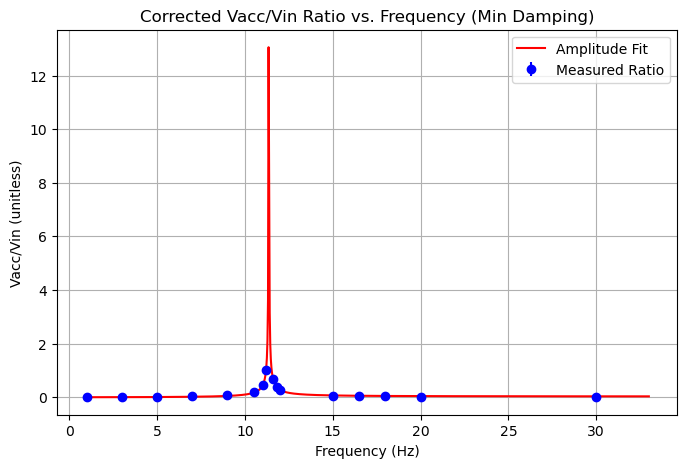

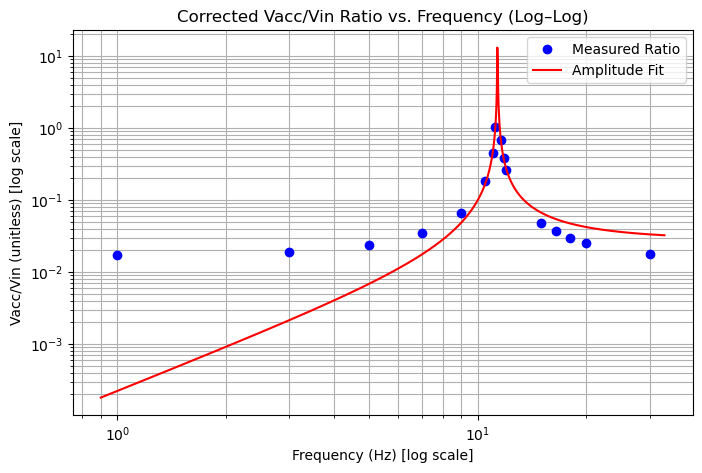

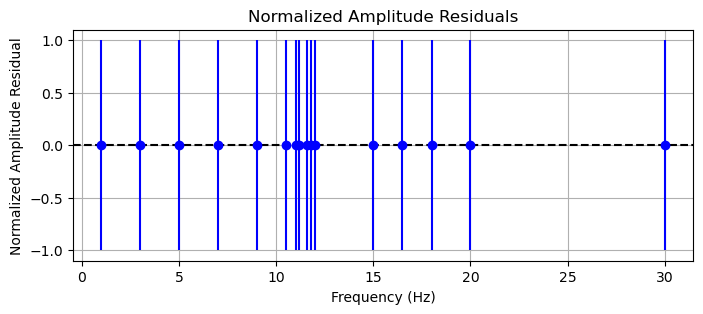

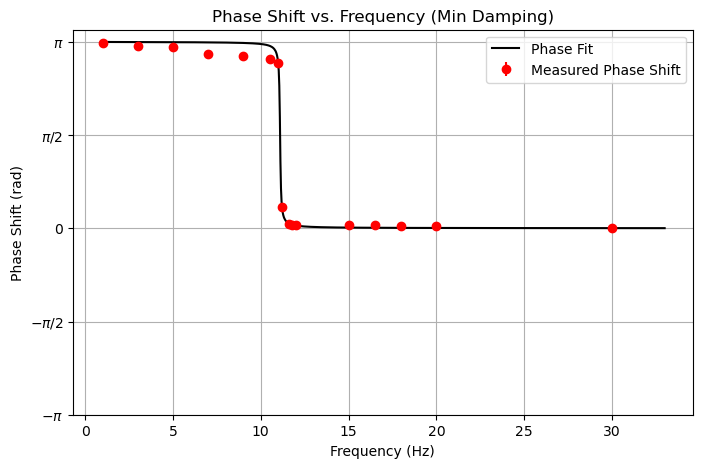

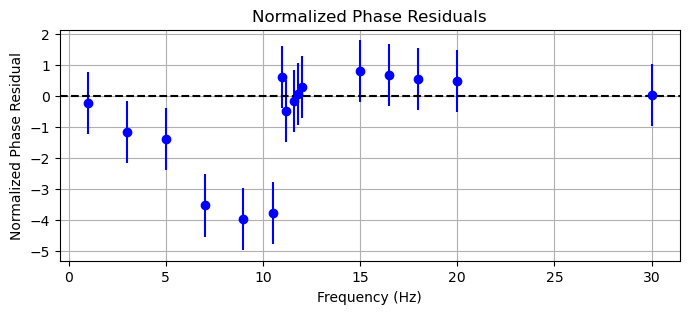

All plots completed for Min Damping.
Saving data to ./ProcessedData/MinDampingRatioData_Normalized.txt...
Data saved to: ./ProcessedData/MinDampingRatioData_Normalized.txt


In [7]:
#####################################
# STEP 7: PLOT THE RESULTS (Quick Fix)
#####################################

# Create delta arrays from your existing uncertainty calculations
delta_V_ratio = sigma_A_ratio * 0.0

# Compute amplitude ratio and residuals
V_ratio = A_vacc_list / A_vin_list
amp_residuals = V_ratio - amplitude_model(freq_list, f0_amp_fit, gamma_amp_fit, C_fit)

# Compute phase residuals (measured vs. fitted phase shift)
phase_residuals = phase_list - phase_model(freq_list, f0_phase_fit, gamma_phase_fit)

# Normalized residuals (dimensionless)
normalized_amp_residuals = amp_residuals / sigma_A_ratio
normalized_phase_residuals = phase_residuals / sigma_phi

# Extended frequency array for smooth fit plot
f_extended = np.linspace(freq_list[0] * 0.9, freq_list[-1] * 1.1, 1000)

# --- Plot Corrected Amplitude Ratio (Linear Scale) ---
plt.figure(figsize=(8, 5))
plt.title("Corrected Vacc/Vin Ratio vs. Frequency (Min Damping)")
plt.errorbar(freq_list, V_ratio, yerr=delta_V_ratio, fmt='bo', label="Measured Ratio")
plt.plot(f_extended, amplitude_model(f_extended, f0_amp_fit, gamma_amp_fit, C_fit), 'r-', label="Amplitude Fit")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Vacc/Vin (unitless)")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Corrected Amplitude Ratio (Log–Log Scale) ---
plt.figure(figsize=(8, 5))
plt.title("Corrected Vacc/Vin Ratio vs. Frequency (Log–Log)")
plt.loglog(freq_list, V_ratio, 'bo', label="Measured Ratio")
plt.loglog(f_extended, amplitude_model(f_extended, f0_amp_fit, gamma_amp_fit, C_fit), 'r-', label="Amplitude Fit")
plt.xlabel("Frequency (Hz) [log scale]")
plt.ylabel("Vacc/Vin (unitless) [log scale]")
plt.grid(True, which="both")
plt.legend()
plt.show()

# --- Normalized Amplitude Residuals (error bars = 1 by definition) ---
plt.figure(figsize=(8, 3))
plt.title("Normalized Amplitude Residuals")
plt.errorbar(freq_list, normalized_amp_residuals, yerr=np.ones_like(normalized_amp_residuals), fmt='o', color='b')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude Residual")
plt.grid(True)
plt.show()

# --- Plot Phase Shift (with correct error bars) ---
plt.figure(figsize=(8, 5))
plt.title("Phase Shift vs. Frequency (Min Damping)")
plt.errorbar(freq_list, phase_list, yerr=sigma_phi, fmt='ro', label="Measured Phase Shift")
plt.plot(f_extended, phase_model(f_extended, f0_phase_fit, gamma_phase_fit), 'k-', label="Phase Fit")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase Shift (rad)")
plt.yticks([np.pi, np.pi/2, 0, -np.pi/2, -np.pi],
           [r'$\pi$', r'$\pi/2$', '0', r'$-\pi/2$', r'$-\pi$'])
plt.grid(True)
plt.legend()
plt.show()

# --- Normalized Phase Residuals (error bars = 1 by definition) ---
plt.figure(figsize=(8, 3))
plt.title("Normalized Phase Residuals")
plt.errorbar(freq_list, normalized_phase_residuals, yerr=np.ones_like(normalized_phase_residuals), fmt='o', color='b')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Phase Residual")
plt.grid(True)
plt.show()

print("All plots completed for Min Damping.")

#####################################
# STEP 9: SAVE PROCESSED DATA TO FILE
#####################################

output_filename = os.path.join(save_dir, "MinDampingRatioData_Normalized.txt")

print(f"Saving data to {output_filename}...")

with open(output_filename, "w") as f:
    f.write("# freq(Hz)\tVaccOverVin\tRatioError\tPhase(rad)\tPhaseError\tNormAmpResidual\tNormPhaseResidual\n")
    for i in range(len(freq_list)):
        f.write(f"{freq_list[i]:.6f}\t{V_ratio[i]:.6f}\t{sigma_A_ratio[i]:.6f}\t"
                f"{phase_list[i]:.6f}\t{sigma_phi:.6f}\t"
                f"{normalized_amp_residuals[i]:.6f}\t{normalized_phase_residuals[i]:.6f}\n")

print(f"Data saved to: {output_filename}")


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Custom frequencies to filter for
custom_freqs = [3, 5, 6.99, 9.9994, 10.49, 10.75, 11.33, 11.59, 11.89, 13.2, 14.599, 16.9998, 24.9996]
tolerance = 0.02

# Compute corrected amplitude ratio
V_ratio_corrected = A_vacc_list / A_vin_list  # Simple ratio (can add correction if needed)

# Build table directly from validated arrays
table_data = []
for i in range(len(freq_list)):
    row = [
        f"{freq_list[i]:.5f}",
        f"{A_vin_list[i]:.4f} ± {A_vin_err_list[i]:.4f}",
        f"{A_vacc_list[i]:.4f} ± {A_vacc_err_list[i]:.4f}",
        f"{A_meas_list[i]:.4f} ± {A_meas_err_list[i]:.4f}",
        f"{phase_list[i]:.4f} ± {phase_err_list[i]:.4f}",
        f"{phase_list[i] * (180/np.pi):.4f} ± {phase_err_list[i] * (180/np.pi):.4f}",
        f"{phi_vacc_list[i] * (180/np.pi):.4f} ± {phi_vacc_err_list[i] * (180/np.pi):.4f}",
        f"{phi_vin_list[i] * (180/np.pi):.4f} ± {phi_vin_err_list[i] * (180/np.pi):.4f}"
    ]
    table_data.append((freq_list[i], row))

# Print full table
headers = [
    "f (Hz)", "A_in(V)", "A_acc(V)", "A_meas(m/s^2)", 
    "PhaseShift(rad)", "PhaseShift(°)", "φ Vacc(°)", "φ Vin(°)"
]
print("\nFinal Processed Data:")
print(tabulate([row for _, row in table_data], headers=headers, tablefmt="simple", floatfmt=".4f"))

# Filter for specific custom frequencies
filtered_table_data = [
    row for freq, row in table_data if any(abs(freq - target) <= tolerance for target in custom_freqs)
]

print("\nFiltered Data (frequencies close to custom frequencies):")
if filtered_table_data:
    print(tabulate(filtered_table_data, headers=headers, tablefmt="simple", floatfmt=".4f"))
else:
    print(f"No frequencies in freq_list matched within ±{tolerance:.2f} Hz.")




Final Processed Data:
  f (Hz)  A_in(V)          A_acc(V)         A_meas(m/s^2)    PhaseShift(rad)    PhaseShift(°)      φ Vacc(°)           φ Vin(°)
--------  ---------------  ---------------  ---------------  -----------------  -----------------  ------------------  ------------------
  1.0000  0.1629 ± 0.0009  0.0028 ± 0.0007  0.0908 ± 0.0227  3.1280 ± 0.0573    179.2186 ± 3.2804  -149.8466 ± 3.0410  -149.0652 ± 3.0410
  3.0000  0.1630 ± 0.0009  0.0031 ± 0.0007  0.1007 ± 0.0227  3.0731 ± 0.0573    176.0753 ± 3.2804  76.3722 ± 3.0410    80.2969 ± 3.0410
  5.0000  0.1630 ± 0.0009  0.0039 ± 0.0007  0.1274 ± 0.0227  3.0580 ± 0.0573    175.2126 ± 3.2804  -83.7864 ± 3.0410   -78.9990 ± 3.0410
  6.9999  0.1631 ± 0.0009  0.0057 ± 0.0007  0.1858 ± 0.0227  2.9317 ± 0.0573    167.9765 ± 3.2804  98.8900 ± 3.0410    110.9136 ± 3.0410
  8.9999  0.1632 ± 0.0009  0.0107 ± 0.0007  0.3474 ± 0.0227  2.8968 ± 0.0573    165.9766 ± 3.2804  -150.9445 ± 3.0410  -136.9212 ± 3.0410
 10.4999  0.1634 ± 0.0009

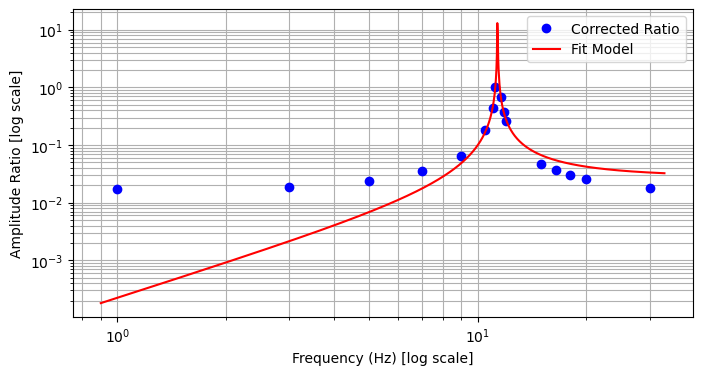

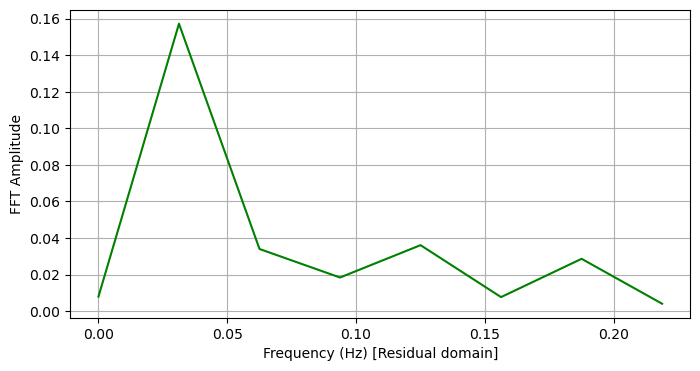

In [9]:
# 1) Log–log plot of amplitude ratio
plt.figure(figsize=(8, 4))
plt.loglog(freq_list, V_ratio_corrected, 'bo', label="Corrected Ratio")
plt.loglog(f_extended, amplitude_model(f_extended, f0_amp_fit, gamma_amp_fit, C_fit), 'r-', label="Fit Model")

plt.xlabel("Frequency (Hz) [log scale]")
plt.ylabel("Amplitude Ratio [log scale]")
plt.grid(True, which='both')
plt.legend()
plt.show()

# 2) FFT analysis of amplitude residuals (just an example)
# Compute residuals correctly
residuals = V_ratio_corrected - amplitude_model(freq_list, f0_amp_fit, gamma_amp_fit, C_fit)

# Compute FFT
residuals_fft = np.fft.fft(residuals)
freq_fft = np.fft.fftfreq(len(residuals), d=(freq_list[1] - freq_list[0]))

# Plot FFT of residuals
plt.figure(figsize=(8, 4))
half = len(freq_fft) // 2  # Take only the positive half of frequencies
plt.plot(freq_fft[:half], np.abs(residuals_fft[:half]), 'g-')
plt.xlabel("Frequency (Hz) [Residual domain]")
plt.ylabel("FFT Amplitude")
plt.grid(True)
plt.show()
